<a href="https://colab.research.google.com/github/lauren1turner/DS4002_LAM/blob/project2/Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-4dc81a308fa9>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


PM2.5 Stationarity Test:
ADF Statistic: -7.9270
p-value: 0.0000
The series is stationary (p <= 0.05).

AQI Stationarity Test:
ADF Statistic: -6.1912
p-value: 0.0000
The series is stationary (p <= 0.05).


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal Lag Order (AIC): 15
MAE for PM2.5: 13.9420
MAE for AQI: 60.8791


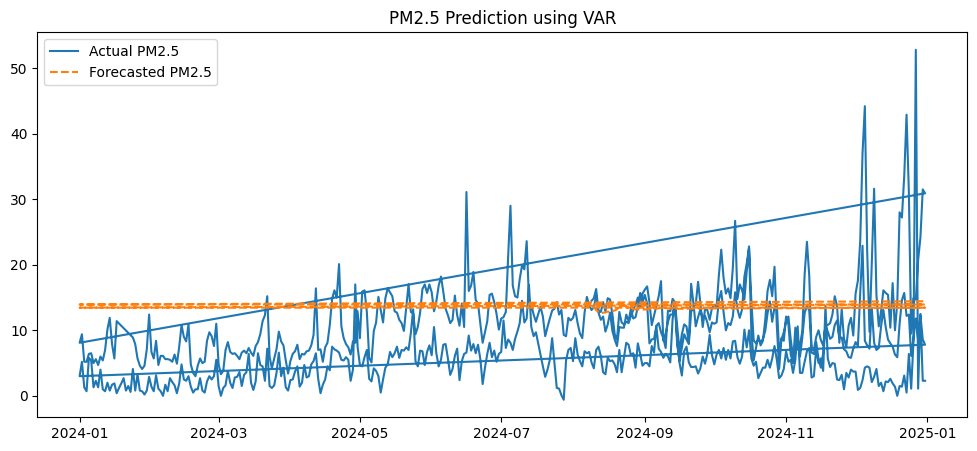

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error

# Load Data
file_path = "PM2.5_2024.csv"  # Update with correct path
df = pd.read_csv(file_path)

# Convert Date column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select relevant columns for VAR
df_var = df[['Daily Mean PM2.5 Concentration', 'Daily AQI Value']]

# Function to check stationarity using Augmented Dickey-Fuller Test
def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] > 0.05:
        print("The series is NOT stationary (p > 0.05), differencing needed.")
    else:
        print("The series is stationary (p <= 0.05).")

# Check stationarity of both variables
print("PM2.5 Stationarity Test:")
check_stationarity(df_var['Daily Mean PM2.5 Concentration'])

print("\nAQI Stationarity Test:")
check_stationarity(df_var['Daily AQI Value'])

# If not stationary, apply first-order differencing
df_diff = df_var.diff().dropna()

# Train-Test Split (80% train, 20% test)
train_size = int(0.8 * len(df_diff))
train, test = df_diff[:train_size], df_diff[train_size:]

# Fit VAR model
model = VAR(train)
lag_selection = model.select_order(maxlags=15)  # Select best lag using AIC/BIC
optimal_lag = lag_selection.aic  # Can also use lag_selection.bic for BIC
print(f"Optimal Lag Order (AIC): {optimal_lag}")

var_model = model.fit(optimal_lag)

# Forecast
forecast_steps = len(test)
forecast = var_model.forecast(train.values, steps=forecast_steps)

# Convert forecasted differenced values back to original scale
forecast_df = pd.DataFrame(forecast, index=test.index, columns=df_diff.columns)
forecast_df = df_var.iloc[train_size-1] + forecast_df.cumsum()

# Evaluate the model
mae_pm25 = mean_absolute_error(test['Daily Mean PM2.5 Concentration'], forecast_df['Daily Mean PM2.5 Concentration'])
mae_aqi = mean_absolute_error(test['Daily AQI Value'], forecast_df['Daily AQI Value'])

print(f"MAE for PM2.5: {mae_pm25:.4f}")
print(f"MAE for AQI: {mae_aqi:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(df_var.index[train_size:], df_var['Daily Mean PM2.5 Concentration'][train_size:], label='Actual PM2.5')
plt.plot(forecast_df.index, forecast_df['Daily Mean PM2.5 Concentration'], label='Forecasted PM2.5', linestyle='dashed')
plt.legend()
plt.title("PM2.5 Prediction using VAR")
plt.show()
